In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from time import time
import matplotlib.colors as colors
import sys
from minimum_energy import Disambiguator

We test if PINNs are able to handle inversion procedure (in our case, simplified case known as weak field approximation [WFA]) 

and magnetic field disambiguation at the same time. In this notebook, we conduct test on synthetic *magnetic flower* configuration.

In [2]:
hdul = fits.open('flower_field_polar_projections.fits')

Bx_flower = hdul['BX_0'].data[::4, ::4]
By_flower = hdul['BY_0'].data[::4, ::4]
Bz_flower = hdul['BZ_0'].data[::4, ::4]
Bz_flower.shape


(128, 128)

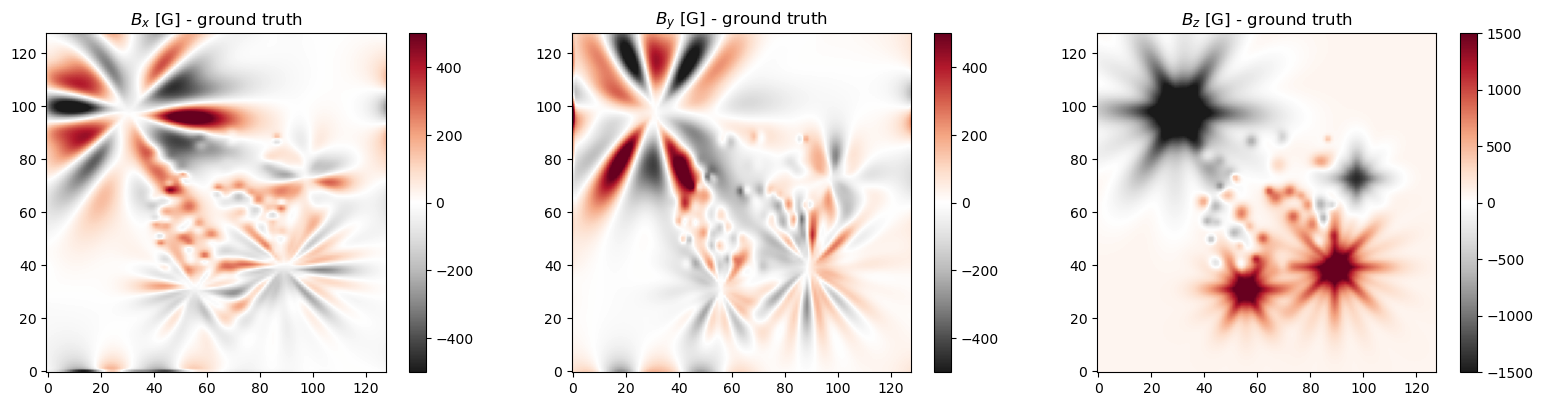

In [3]:
plt.figure(figsize=(16, 4))
plt.subplot(131)
plt.imshow(Bx_flower, origin='lower', cmap='RdGy_r', vmin=-500, vmax=500)
plt.title(r'$B_x$ [G] - ground truth')
plt.colorbar()
plt.subplot(132)
plt.imshow(By_flower, origin='lower', cmap='RdGy_r', vmin=-500, vmax=500)
plt.title(r'$B_y$ [G] - ground truth')
plt.colorbar()
plt.subplot(133)
plt.imshow(Bz_flower, origin='lower', cmap='RdGy_r', vmin=-1500, vmax=1500)
plt.title(r'$B_z$ [G] - ground truth')
plt.colorbar()
plt.tight_layout()
plt.show()

We need to create Stokes profiles that are going to be treated as ground truth profiles. For Stokes $I$ we use:

$$
I = 1.0 - \gamma e^{-(\lambda-\lambda_0)^2/2\sigma^2}.
$$

Arbitrary wavelength grid around the line center is okay for this case (Fe I $6301.5\AA$).

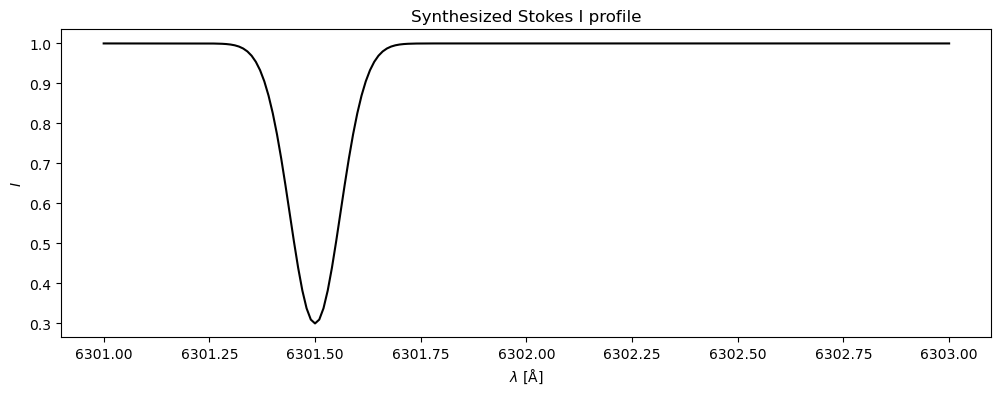

In [3]:
ll = np.linspace(6301, 6303, 201) 
l0 = 6301.5
sigma = 0.06

I_profile = 1.0 - 0.7 * np.exp(-(ll - l0)**2 / (2*sigma**2))

ny, nx = Bx_flower.shape
I_stokes = np.tile(I_profile, (ny, nx, 1))

plt.figure(figsize=(12, 4))
plt.plot(ll, I_stokes[50, 50, :], c='black')
plt.xlabel('$\lambda$ [Å]')
plt.ylabel('$I$')
plt.title('Synthesized Stokes I profile')
plt.show()

In WFA approximation, Stokes $V$ is given as (constants are known):

$$
V = -C \frac{dI}{d\lambda} \lambda_0^2 g_{\text{eff}} B_z.
$$

For Stokes $Q$ and $U$, we can use something that resembles second derivative:

$$
P \propto \left(\frac{dI}{d\lambda}\right)^2 \cdot B_T^2,
$$

$$
Q = P \cos(2\chi), \quad U = P \sin(2\chi),\,\,\chi\,-\,\text{azimuthal angle}.
$$


Here, $Q$/$U$ use $(\partial I/\partial\lambda)^2$ instead of $\partial^2I/\partial\lambda^2$ to avoid numerical instability.

In [19]:
def synthesize_stokes_V_wfa_numpy(Bz, I_profile, ll, g_eff=1.67, lambda0=6301.5):
    ny, nx, n_lambda = I_profile.shape
    
    dll = ll[1] - ll[0]
    dI_dl = np.gradient(I_profile, axis=2) / dll
    
    C = 4.67e-13
    lambda_sq = lambda0**2
    Bz_expanded = Bz[:, :, np.newaxis]
    V_synth = -C * dI_dl * lambda_sq * g_eff * Bz_expanded
    
    return V_synth

def synthesize_stokes_QU_wfa_numpy(Bx, By, I_profile, ll, scale_factor=1e-4):
    ny, nx, n_lambda = I_profile.shape
    
    dll = ll[1] - ll[0]
    dI_dl = np.gradient(I_profile, axis=2) / dll
    
    Bx_expanded = Bx[:, :, np.newaxis]
    By_expanded = By[:, :, np.newaxis]
    
    BT_sq = Bx_expanded**2 + By_expanded**2
    P_synth = scale_factor * dI_dl**2 * BT_sq
    
    chi = np.arctan2(By_expanded, Bx_expanded)
    Q_synth = P_synth * np.cos(2 * chi)
    U_synth = P_synth * np.sin(2 * chi)
    
    return Q_synth, U_synth

We proceed to synthesize Stokes parameters that will serve as *original* ones.

In [20]:
V_flower_gt = synthesize_stokes_V_wfa_numpy(Bz_flower, I_stokes, ll)
Q_flower_gt, U_flower_gt = synthesize_stokes_QU_wfa_numpy(Bx_flower, By_flower, I_stokes, ll, scale_factor=1e-8)

print(f"V range: [{V_flower_gt.min():.3e}, {V_flower_gt.max():.3e}]")
print(f"Q range: [{Q_flower_gt.min():.3e}, {Q_flower_gt.max():.3e}]")
print(f"U range: [{U_flower_gt.min():.3e}, {U_flower_gt.max():.3e}]")

V range: [-5.246e-01, 5.246e-01]
Q range: [-1.635e-01, 2.118e-01]
U range: [-2.267e-01, 1.836e-01]


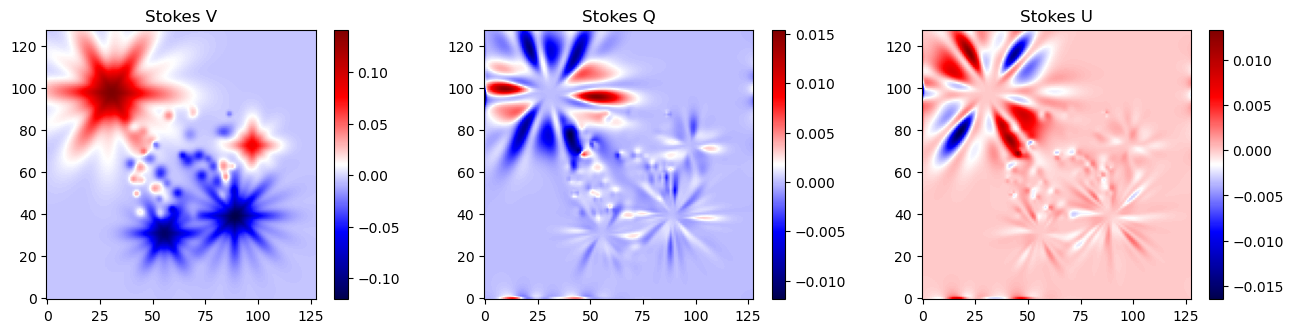

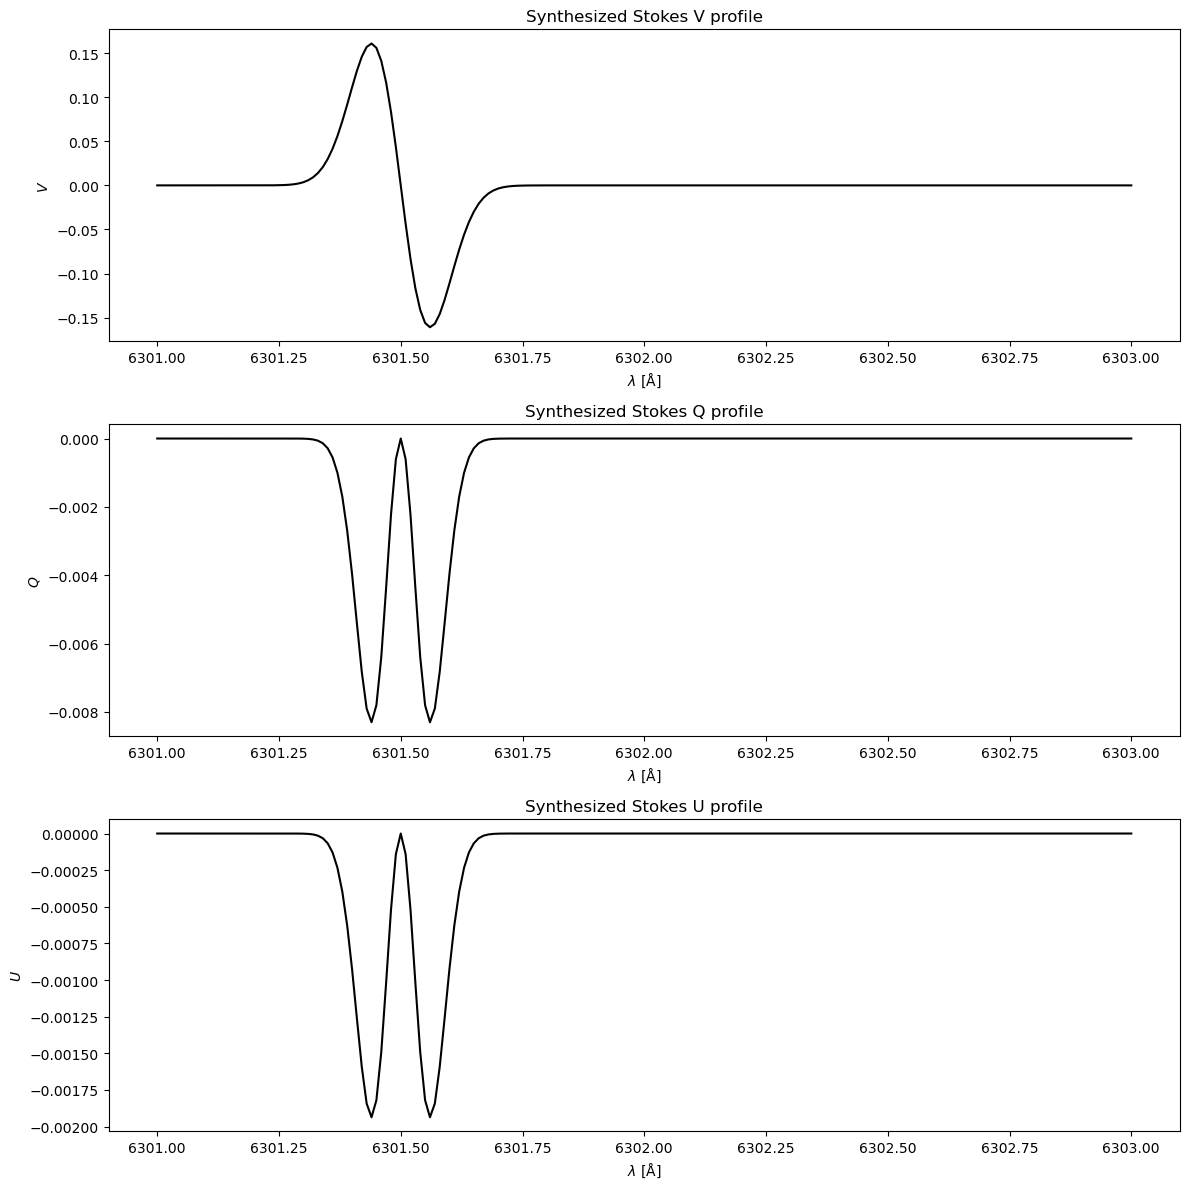

In [21]:
plt.figure(figsize=(16,3.5))
plt.subplot(131)
plt.imshow(V_flower_gt[:,:,51], cmap='seismic', origin='lower')
plt.colorbar()
plt.title('Stokes V')

plt.subplot(132)
plt.imshow(Q_flower_gt[:,:,51], cmap='seismic', origin='lower')
plt.colorbar()
plt.title('Stokes Q')

plt.subplot(133)
plt.imshow(U_flower_gt[:,:,51], cmap='seismic', origin='lower')
plt.colorbar()
plt.title('Stokes U')
plt.show()

plt.figure(figsize=(12, 12))
plt.subplot(311)
plt.plot(ll, V_flower_gt[20,50,:], c='black')
plt.xlabel('$\lambda$ [Å]')
plt.ylabel('$V$')
plt.title('Synthesized Stokes V profile')
plt.subplot(312)
plt.plot(ll, Q_flower_gt[20,50,:], c='black')
plt.xlabel('$\lambda$ [Å]')
plt.ylabel('$Q$')
plt.title('Synthesized Stokes Q profile')
plt.subplot(313)
plt.plot(ll, U_flower_gt[20,50,:], c='black')
plt.xlabel('$\lambda$ [Å]')
plt.ylabel('$U$')
plt.title('Synthesized Stokes U profile')   
plt.tight_layout()
plt.show()

We select wavelength range of interest - numerical reasons.

In [22]:
line_core_start = 35 
line_core_end = 65
ll_core = ll[line_core_start:line_core_end]  

I_core = I_stokes[:, :, line_core_start:line_core_end]  
V_core = V_flower_gt[:, :, line_core_start:line_core_end]
Q_core = Q_flower_gt[:, :, line_core_start:line_core_end]
U_core = U_flower_gt[:, :, line_core_start:line_core_end]

stokes_flower = np.stack([I_core, Q_core, U_core, V_core], axis=2)
print(f"stokes_flower shape: {stokes_flower.shape}")

stokes_flower shape: (128, 128, 4, 30)


In order to learn mapping from *observations* to magnetic field, we use U-Net architecture:

$$
\text{U-Net}: (I, Q, U, V)_{\lambda} \rightarrow (B_x, B_y, B_z).
$$

In [23]:
device = torch.device('cpu')

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.enc1 = self.conv_block(in_channels, 16)
        self.enc2 = self.conv_block(16, 32)
        self.pool = nn.MaxPool2d(2)
        
        self.bottleneck = self.conv_block(32, 64)
        
        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec1 = self.conv_block(64, 32)
        self.up2 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.dec2 = self.conv_block(32, 16)
        
        self.out = nn.Conv2d(16, out_channels, 1)
    
    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU())
    
    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        
        b = self.bottleneck(self.pool(e2))
        
        d1 = self.up1(b)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec1(d1)
        
        d2 = self.up2(d1)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec2(d2)
        
        return self.out(d2)

In order to synthesize Stokes $V$, $Q$ and $U$ from predicted magnetic field (during PINN training loop network predicts

$B_x, B_y, B_z$) we need PyTorch versions of these functions. They are used every training iteration inside loss function

and that's how gradients $\frac{\partial \mathcal{L}}{\partial B_x}, \frac{\partial \mathcal{L}}{\partial B_y}, \frac{\partial \mathcal{L}}{\partial B_z}$ are computed.

In [24]:

def synthesize_stokes_V_wfa(Bz, I_profile, ll, g_eff=1.67, lambda0=6301.5):
    batch, ny, nx, n_lambda = I_profile.shape
    
    dll = ll[1] - ll[0]
    dI_dl = torch.gradient(I_profile, dim=3)[0] / dll
    
    C = 4.67e-13
    lambda_sq = lambda0**2
    Bz_expanded = Bz.unsqueeze(-1).expand(-1, -1, -1, n_lambda)
    V_synth = -C * dI_dl * lambda_sq * g_eff * Bz_expanded
    
    return V_synth

def synthesize_stokes_QU_wfa(Bx, By, I_profile, ll, scale_factor=1e-8):
    batch, ny, nx, n_lambda = I_profile.shape
    
    dll = ll[1] - ll[0]
    dI_dl = torch.gradient(I_profile, dim=3)[0] / dll
    
    Bx_expanded = Bx.unsqueeze(-1).expand(-1, -1, -1, n_lambda)
    By_expanded = By.unsqueeze(-1).expand(-1, -1, -1, n_lambda)
    
    BT_sq = Bx_expanded**2 + By_expanded**2
    P_synth = scale_factor * dI_dl**2 * BT_sq
    
    chi = torch.atan2(By_expanded, Bx_expanded)
    Q_synth = P_synth * torch.cos(2 * chi)
    U_synth = P_synth * torch.sin(2 * chi)
    
    return Q_synth, U_synth

We need to include disambiguation somewhere. Since our disambiguation procedure "needs" $\frac{\partial B_z}{\partial z}$ to work properly, 

we determine it using spectral method (simplified notation below):

$$
\frac{\partial f}{\partial x} \xrightarrow{\text{FFT}} ik_x \hat{f}(k_x, k_y).
$$

Full terms of energy functional (so-called minimum energy method) are calculated like:


$$
\nabla \cdot \vec{B} = \frac{\partial B_x}{\partial x} + \frac{\partial B_y}{\partial y} + \frac{\partial B_z}{\partial z},
$$

$$
j_z = \frac{\partial B_y}{\partial x} - \frac{\partial B_x}{\partial y}.
$$

Loss function is (for *inversion* only):

$$
\mathcal{L}
 = \alpha \left|\left| \frac{V_{\text{obs}} - V_{\text{WFA}}(B_z)}{\sigma_V} \right|\right|^2 + \beta \left|\left| \frac{Q_{\text{obs}} - Q_{\text{WFA}}(B_x, B_y)}{\sigma_Q} \right|\right|^2 + \gamma \left|\left| \frac{U_{\text{obs}} - U_{\text{WFA}}(B_x, B_y)}{\sigma_U} \right|\right|^2 
 $$

In [25]:
def physics_loss(B_pred, stokes_obs, ll, alpha=1.0, beta=1.0, gamma=1.0, dx=1.0, dy=1.0):
    
    Bx_pred = B_pred[:, 0, :, :]
    By_pred = B_pred[:, 1, :, :]
    Bz_pred = B_pred[:, 2, :, :]
    
    I_obs = stokes_obs[:, :, :, 0, :]
    Q_obs = stokes_obs[:, :, :, 1, :]
    U_obs = stokes_obs[:, :, :, 2, :]
    V_obs = stokes_obs[:, :, :, 3, :]
    
    V_synth = synthesize_stokes_V_wfa(Bz_pred, I_obs, ll)
    Q_synth, U_synth = synthesize_stokes_QU_wfa(Bx_pred, By_pred, I_obs, ll, scale_factor=1e-8)
    V_std = torch.std(V_obs) + 1e-10
    Q_std = torch.std(Q_obs) + 1e-10
    U_std = torch.std(U_obs) + 1e-10
    
    residual_V = (V_obs - V_synth) / V_std
    residual_Q = (Q_obs - Q_synth) / Q_std
    residual_U = (U_obs - U_synth) / U_std
    
    loss_V = torch.mean(residual_V**2)
    loss_Q = torch.mean(residual_Q**2)
    loss_U = torch.mean(residual_U**2)
    
    total_loss = alpha * loss_V + beta * loss_Q + gamma * loss_U
    
    return total_loss, loss_V, loss_Q, loss_U

Before, we selected wavelength window $\lambda\in [i:j]$ (centered on line core). We stack Stokes arrays $[n_y, n_x, 4, n_\lambda]$.

Reshaping for U-Net input has to be done too (for example, $n_\lambda=30$):
   - original: $[n_y, n_x, 4, 30]$,
   - permute: $[1, 4, 30, n_y, n_x]$,
   - reshape: $[1, 120, n_y, n_x]$ = [batch, channels, height, width],
   - $120$ channels = 4 Stokes parameters × 30 wavelengths.

In [111]:
stokes_core = stokes_flower
n_wavelengths_core = len(ll_core)
in_channels = 4 * n_wavelengths_core
out_channels = 3

model = UNet(in_channels, out_channels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100, factor=0.5)

ll_tensor = torch.tensor(ll_core, dtype=torch.float32, device=device)

stokes_torch = torch.from_numpy(stokes_core.astype(np.float32)).to(device)
stokes_torch = stokes_torch.unsqueeze(0)

ny, nx = stokes_core.shape[0], stokes_core.shape[1]
stokes_input = stokes_torch.permute(0, 3, 4, 1, 2)
stokes_input = stokes_input.reshape(1, -1, ny, nx)

print(f"Input channels: {in_channels}")
print(f"Output channels: {out_channels}")
print(f"Wavelength range: {n_wavelengths_core} points")
print(f"V observed range: [{stokes_core[:,:,3,:].min():.3e}, {stokes_core[:,:,3,:].max():.3e}]")
print(f"Q observed range: [{stokes_core[:,:,1,:].min():.3e}, {stokes_core[:,:,1,:].max():.3e}]")
print(f"U observed range: [{stokes_core[:,:,2,:].min():.3e}, {stokes_core[:,:,2,:].max():.3e}]")

Input channels: 120
Output channels: 3
Wavelength range: 30 points
V observed range: [-5.246e-01, 5.246e-01]
Q observed range: [-1.635e-01, 2.118e-01]
U observed range: [-2.267e-01, 1.836e-01]


**Training time**. Again, no disambiguation is being implemented.

In [27]:
start = time()
alpha, beta, gamma = 1.0, 1.0, 1.0
n_epochs = 1500
loss_history = []
loss_V_history = []
loss_Q_history = []
loss_U_history = []

best_loss = float('inf')
patience_counter = 0
early_stop_patience = 100

for epoch in tqdm(range(n_epochs), desc="Training"):
    optimizer.zero_grad()
    
    B_pred = model(stokes_input)
    loss, loss_V, loss_Q, loss_U = physics_loss(
    B_pred, stokes_torch, ll_tensor)

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step(loss)
    
    loss_history.append(loss.item())
    loss_V_history.append(loss_V.item())
    loss_Q_history.append(loss_Q.item())
    loss_U_history.append(loss_U.item())

    if loss.item() < best_loss - 1e-4:
        best_loss = loss.item()
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stop_patience:
        print(f"Early stopping at epoch {epoch}")
        break

    if epoch % 150 == 0:
        Bx_range = B_pred[0, 0, :, :].detach()
        By_range = B_pred[0, 1, :, :].detach()
        Bz_range = B_pred[0, 2, :, :].detach()
       
        tqdm.write(f"Epoch {epoch}, Loss: {loss.item():.6e}, V: {loss_V.item():.6e}, Q: {loss_Q.item():.6e}, U: {loss_U.item():.6e}")
        tqdm.write(f"  Bx: [{Bx_range.min():.1f}, {Bx_range.max():.1f}], By: [{By_range.min():.1f}, {By_range.max():.1f}], Bz: [{Bz_range.min():.1f}, {Bz_range.max():.1f}]")

end = time()
print(f"Procedure lasted for {end - start:.2f} seconds")

Training:   0%|          | 1/1500 [00:00<08:57,  2.79it/s]

Epoch 0, Loss: 3.000103e+00, V: 1.000002e+00, Q: 1.000079e+00, U: 1.000023e+00
  Bx: [0.2, 0.2], By: [-0.2, -0.2], Bz: [-0.0, -0.0]


Training:  10%|█         | 151/1500 [00:38<04:21,  5.17it/s]

Epoch 150, Loss: 1.826913e+00, V: 2.500011e-01, Q: 8.564329e-01, U: 7.204788e-01
  Bx: [-4.2, 356.5], By: [-662.2, 87.0], Bz: [-2347.6, 1871.6]


Training:  20%|██        | 301/1500 [01:12<04:50,  4.13it/s]

Epoch 300, Loss: 7.835870e-01, V: 9.017221e-02, Q: 2.564019e-01, U: 4.370130e-01
  Bx: [-759.7, 357.8], By: [-666.0, 137.0], Bz: [-1903.0, 1813.1]


Training:  30%|███       | 451/1500 [01:47<04:14,  4.11it/s]

Epoch 450, Loss: 2.175072e-01, V: 2.715485e-02, Q: 9.270302e-02, U: 9.764934e-02
  Bx: [-606.4, 389.4], By: [-602.5, 205.7], Bz: [-2181.6, 1979.4]


Training:  40%|████      | 601/1500 [02:47<03:19,  4.51it/s]

Epoch 600, Loss: 1.244711e-01, V: 1.409966e-02, Q: 4.887640e-02, U: 6.149508e-02
  Bx: [-646.5, 396.8], By: [-645.7, 221.8], Bz: [-2245.4, 1893.6]


Training:  50%|█████     | 751/1500 [03:29<03:38,  3.42it/s]

Epoch 750, Loss: 6.423455e-02, V: 8.160754e-03, Q: 2.514111e-02, U: 3.093269e-02
  Bx: [-646.2, 366.7], By: [-632.3, 544.2], Bz: [-2372.7, 2001.6]


Training:  60%|██████    | 901/1500 [04:02<01:56,  5.15it/s]

Epoch 900, Loss: 4.986177e-02, V: 7.055438e-03, Q: 2.143758e-02, U: 2.136876e-02
  Bx: [-630.2, 354.4], By: [-630.9, 576.0], Bz: [-2390.6, 1979.3]


Training:  70%|███████   | 1051/1500 [04:47<01:47,  4.19it/s]

Epoch 1050, Loss: 5.353414e-02, V: 5.436654e-03, Q: 2.279157e-02, U: 2.530591e-02
  Bx: [-669.1, 347.3], By: [-634.3, 633.1], Bz: [-2374.1, 2069.0]


Training:  80%|████████  | 1201/1500 [05:21<01:10,  4.27it/s]

Epoch 1200, Loss: 2.094351e-02, V: 3.779036e-03, Q: 8.746161e-03, U: 8.418311e-03
  Bx: [-637.3, 367.5], By: [-611.1, 575.3], Bz: [-2335.8, 2036.1]


Training:  90%|█████████ | 1351/1500 [05:58<00:29,  5.08it/s]

Epoch 1350, Loss: 2.066841e-02, V: 3.229726e-03, Q: 9.229692e-03, U: 8.208993e-03
  Bx: [-643.0, 370.4], By: [-634.2, 570.1], Bz: [-2358.8, 2052.1]


Training:  98%|█████████▊| 1467/1500 [06:24<00:08,  3.82it/s]

Early stopping at epoch 1467
Procedure lasted for 384.46 seconds


We finalize our procedure and obtain final magnetic field components.

In [28]:
Bx_pred = B_pred[0, 0, :, :].unsqueeze(0)  
By_pred = B_pred[0, 1, :, :].unsqueeze(0)  
Bz_pred = B_pred[0, 2, :, :].unsqueeze(0) 

I_obs_torch = stokes_torch[:, :, :, 0, :]  

V_synth = synthesize_stokes_V_wfa(Bz_pred, I_obs_torch, ll_tensor)
Q_synth, U_synth = synthesize_stokes_QU_wfa(Bx_pred, By_pred, I_obs_torch, ll_tensor, scale_factor=1e-8)

Bx_pred = Bx_pred[0].detach().cpu().numpy() 
By_pred = By_pred[0].detach().cpu().numpy()
Bz_pred = Bz_pred[0].detach().cpu().numpy()

V_pred = V_synth[0, :, :, :].detach().cpu().numpy()
Q_pred = Q_synth[0, :, :, :].detach().cpu().numpy()
U_pred = U_synth[0, :, :, :].detach().cpu().numpy()

V_obs = stokes_torch[0, :, :, 3, :].detach().cpu().numpy()
Q_obs = stokes_torch[0, :, :, 1, :].detach().cpu().numpy()
U_obs = stokes_torch[0, :, :, 2, :].detach().cpu().numpy()

print(f"\nGround truth Bx range: [{Bx_flower.min():.1f}, {Bx_flower.max():.1f}] G")
print(f"Ground truth By range: [{By_flower.min():.1f}, {By_flower.max():.1f}] G")
print(f"Ground truth Bz range: [{Bz_flower.min():.1f}, {Bz_flower.max():.1f}] G")
print(f"\nFinal Bx range: [{Bx_pred.min():.1f}, {Bx_pred.max():.1f}] G")
print(f"Final By range: [{By_pred.min():.1f}, {By_pred.max():.1f}] G")
print(f"Final Bz range: [{Bz_pred.min():.1f}, {Bz_pred.max():.1f}] G")


Ground truth Bx range: [-645.3, 656.4] G
Ground truth By range: [-615.5, 630.2] G
Ground truth Bz range: [-2416.1, 2062.0] G

Final Bx range: [-652.0, 353.5] G
Final By range: [-611.4, 591.1] G
Final Bz range: [-2377.8, 2014.1] G


We need to check correlations between predicted and ground truth versions. Amplitudes matter too.

In [29]:
cc_Bx = np.corrcoef(Bx_flower.flatten(), Bx_pred.flatten())[0][1]
cc_By = np.corrcoef(By_flower.flatten(), By_pred.flatten())[0][1]
cc_Bz = np.corrcoef(Bz_flower.flatten(), Bz_pred.flatten())[0][1]
print(f"Bx correlation: {cc_Bx:.3f}, By correlation: {cc_By:.3f}, Bz correlation: {cc_Bz:.3f}")

cc_V = np.corrcoef(V_obs.flatten(), V_pred.flatten())[0][1]
cc_Q = np.corrcoef(Q_obs.flatten(), Q_pred.flatten())[0][1]
cc_U = np.corrcoef(U_obs.flatten(), U_pred.flatten())[0][1]
print(f"V correlation: {cc_V:.3f}, Q correlation: {cc_Q:.3f}, U correlation: {cc_U:.3f}")

Bt_pred = np.sqrt(Bx_pred**2 + By_pred**2)
Bt_true = np.sqrt(Bx_flower**2 + By_flower**2)

print(f"B transverse magnitude correlation: {np.corrcoef(Bt_pred.flat, Bt_true.flat)[0,1]:.3f}")

total_params = sum(p.numel() for p in model.parameters())
print(f"Total trainable parameters (is our U-Net good enough?): {total_params}")

Bx correlation: -0.043, By correlation: 0.013, Bz correlation: 0.999
V correlation: 0.998, Q correlation: 0.995, U correlation: 0.995
B transverse magnitude correlation: 0.983
Total trainable parameters (is our U-Net good enough?): 133923


We plot various magnetic field components and Stokes parameters (ground truth vs predicted). We plot loss functions too.

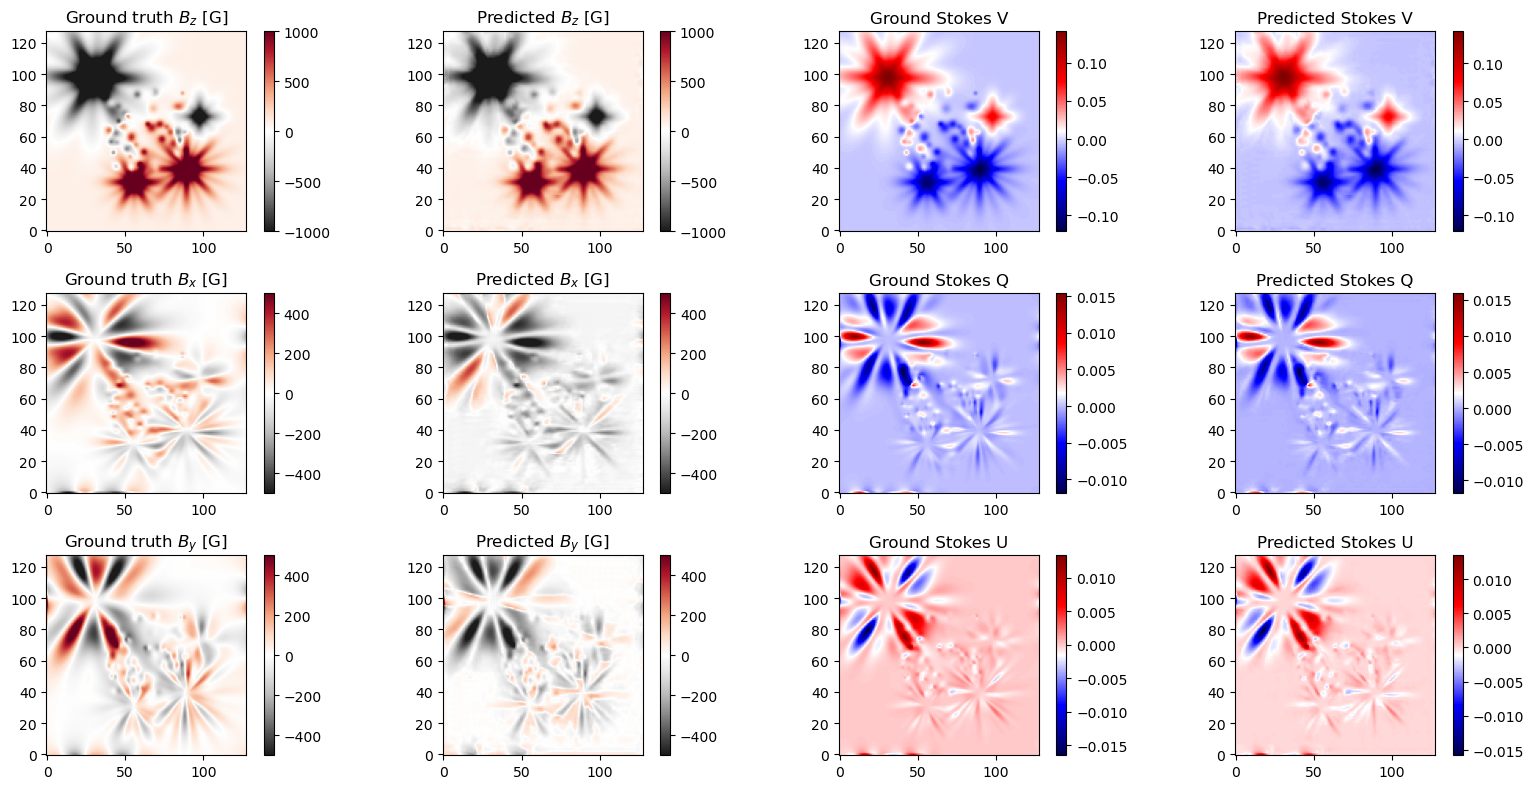

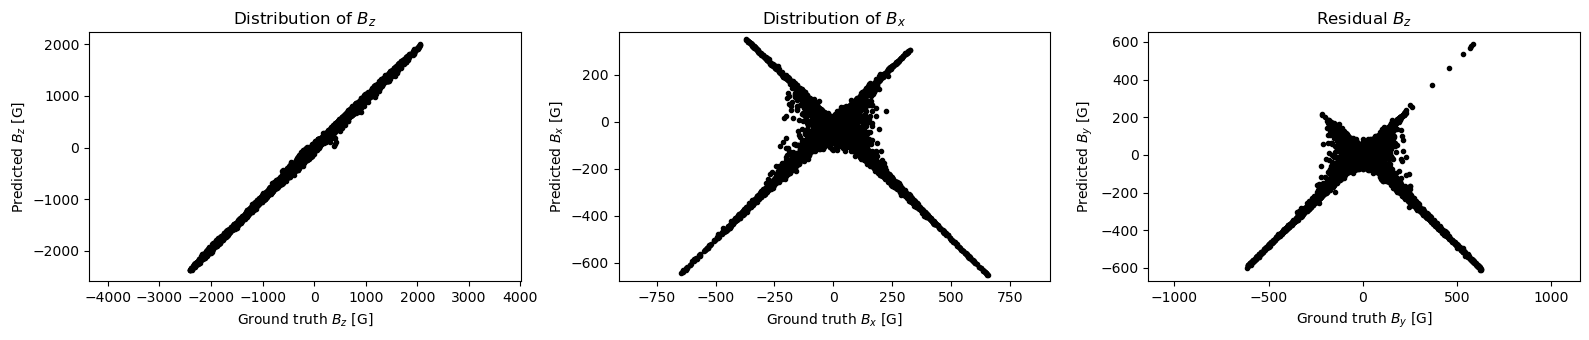

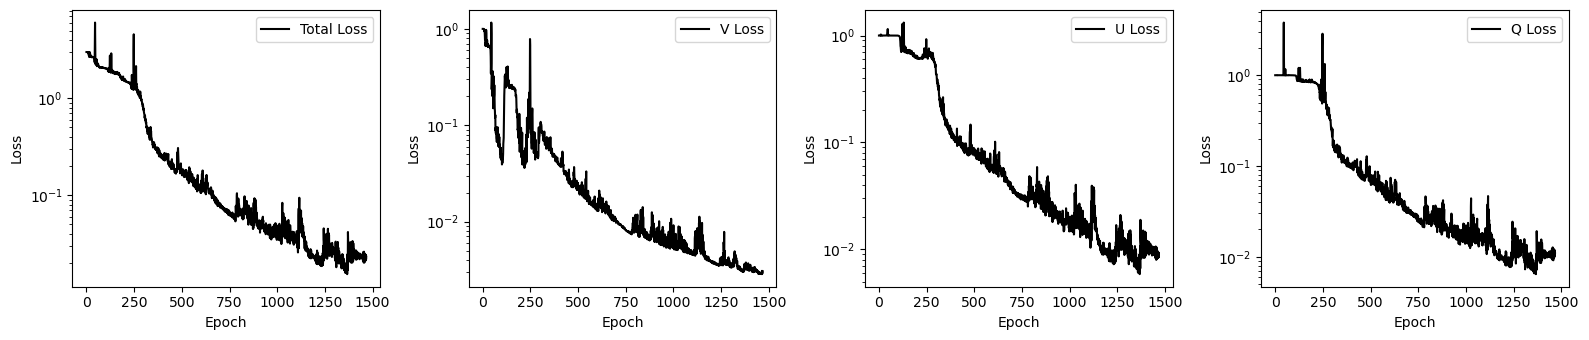

In [30]:
plt.figure(figsize=(16, 8))
plt.subplot(341)
plt.imshow(Bz_flower, origin='lower', cmap='RdGy_r', vmin=-1000, vmax=1000)
plt.colorbar()
plt.title(r'Ground truth $B_z$ [G]')
plt.subplot(342)
plt.imshow(Bz_pred, origin='lower', cmap='RdGy_r', vmin=-1000, vmax=1000)
plt.colorbar()
plt.title(r'Predicted $B_z$ [G]')
plt.subplot(343)
plt.imshow(V_obs[:,:,16], origin='lower', cmap='seismic')
plt.colorbar()
plt.title(r'Ground Stokes V')
plt.subplot(344)
plt.imshow(V_pred[:,:,16], origin='lower', cmap='seismic')
plt.colorbar()
plt.title(r'Predicted Stokes V')
plt.subplot(345)
plt.imshow(Bx_flower, origin='lower', cmap='RdGy_r', vmin=-500, vmax=500)
plt.colorbar()
plt.title(r'Ground truth $B_x$ [G]')
plt.subplot(346)
plt.imshow(Bx_pred, origin='lower', cmap='RdGy_r',vmin=-500, vmax=500)
plt.colorbar()
plt.title(r'Predicted $B_x$ [G]')
plt.subplot(347)
plt.imshow(Q_obs[:,:,16], origin='lower', cmap='seismic')
plt.colorbar()
plt.title(r'Ground Stokes Q')
plt.subplot(348)
plt.imshow(Q_pred[:,:,16], origin='lower', cmap='seismic')
plt.colorbar()
plt.title(r'Predicted Stokes Q')
plt.subplot(349)
plt.imshow(By_flower, origin='lower', cmap='RdGy_r', vmin=-500, vmax=500)
plt.colorbar()
plt.title(r'Ground truth $B_y$ [G]')
plt.subplot(3,4,10)
plt.imshow(By_pred, origin='lower', cmap='RdGy_r', vmin=-500, vmax=500)
plt.colorbar()
plt.title(r'Predicted $B_y$ [G]')
plt.subplot(3,4,11)
plt.imshow(U_obs[:,:,16], origin='lower', cmap='seismic')
plt.colorbar()
plt.title(r'Ground Stokes U')
plt.subplot(3,4,12)
plt.imshow(U_pred[:,:,16], origin='lower', cmap='seismic')
plt.colorbar()
plt.title(r'Predicted Stokes U')
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 3.5))
plt.subplot(131)
plt.plot(Bz_flower.flatten(), Bz_pred.flatten(), 'k.')
plt.title('Distribution of $B_z$')
plt.xlabel('Ground truth $B_z$ [G]')
plt.ylabel('Predicted $B_z$ [G]')
plt.axis('equal')
plt.subplot(132)
plt.plot(Bx_flower.flatten(), Bx_pred.flatten(), 'k.')
plt.title('Distribution of $B_x$')
plt.xlabel('Ground truth $B_x$ [G]')
plt.ylabel('Predicted $B_x$ [G]')
plt.axis('equal')
plt.subplot(133)
plt.plot(By_flower.flatten(), By_pred.flatten(), 'k.')
plt.title('Distribution of $B_y$')
plt.xlabel('Ground truth $B_y$ [G]')
plt.ylabel('Predicted $B_y$ [G]')
plt.axis('equal')
plt.title(r'Residual $B_z$')
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,3.5))
plt.subplot(141)
plt.semilogy(loss_history, label='Total Loss', color='black')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(142)
plt.semilogy(loss_V_history, label='V Loss', color='black')
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.legend()
plt.subplot(143)
plt.semilogy(loss_U_history, label='U Loss', color='black')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(144)
plt.semilogy(loss_Q_history, label='Q Loss', color='black')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

From results so far we can see that Stokes parameters are recovered almost perfectly. Stokes $V$ doesn't have

ambiguity problem so $B_z$ is also recovered well. $B_x$ and $B_y$ couldn't be recovered - **we need disamiguation**.

$B_x$ / $B_y$ correlations near zero mean the network learned $B_T$ magnitude well (through $Q^2+U^2$) but assigned 

azimuth angles randomly. The network has no way to prefer $\chi$ over $\chi+180°$. For example, Milne-Eddington

inversion returns a deterministic answer (it converges to one of the two minima depending on initialization).


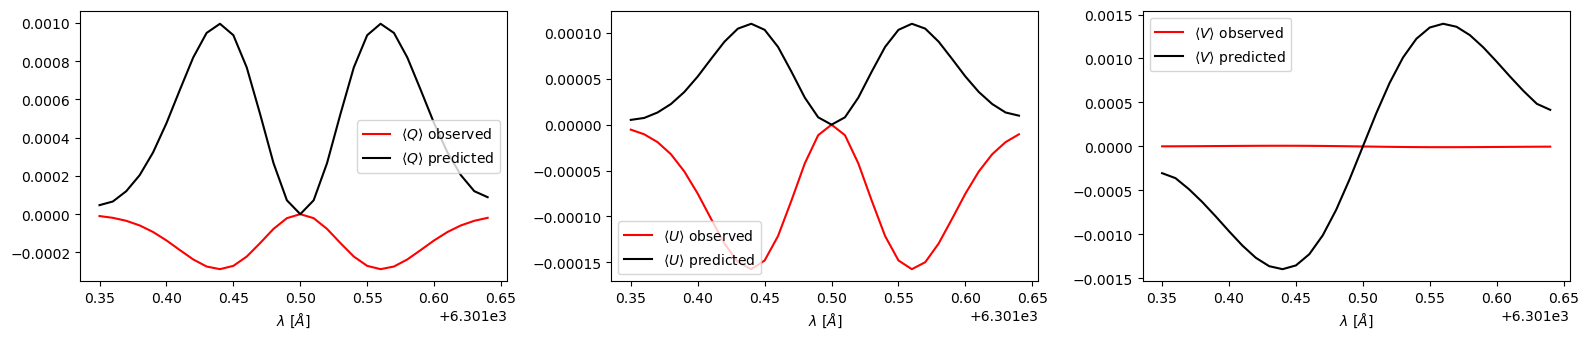

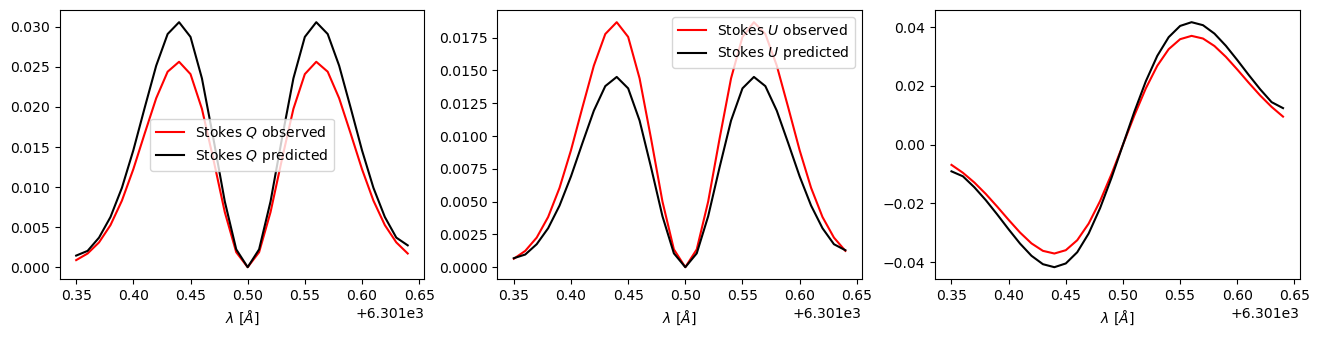

In [31]:
Q_obs_mean = []
Q_pred_mean = []
V_obs_mean = []
V_pred_mean = []
U_obs_mean = []
U_pred_mean = []

for i in range(len(ll_core)):
    Q_slice = Q_obs[:,:,i]
    Q_obs_mean.append(np.mean(Q_slice))
    Q_slice_pred = Q_pred[:,:,i]
    Q_pred_mean.append(np.mean(Q_slice_pred))

    U_slice = U_obs[:,:,i]
    U_obs_mean.append(np.mean(U_slice))
    U_slice_pred = U_pred[:,:,i]
    U_pred_mean.append(np.mean(U_slice_pred))
    
    V_slice = V_obs[:,:,i]
    V_obs_mean.append(np.mean(V_slice))
    V_slice_pred = V_pred[:,:,i]
    V_pred_mean.append(np.mean(V_slice_pred))

plt.figure(figsize=(16,3.5))
plt.subplot(131)
plt.plot(ll_core, Q_obs_mean, label=r'$\langle Q\rangle$ observed', color='red')
plt.plot(ll_core, Q_pred_mean, label=r'$\langle Q\rangle$ predicted', color='black')
plt.xlabel(r'$\lambda$ [$\AA$]')
plt.legend()
plt.subplot(132)
plt.plot(ll_core, U_obs_mean, label=r'$\langle U\rangle$ observed', color='red')
plt.plot(ll_core, U_pred_mean, label=r'$\langle U\rangle$ predicted', color='black')
plt.xlabel(r'$\lambda$ [$\AA$]')
plt.legend()
plt.subplot(133)
plt.plot(ll_core, V_obs_mean, label=r'$\langle V\rangle$ observed', color='red')
plt.plot(ll_core, V_pred_mean, label=r'$\langle V\rangle$ predicted', color='black')
plt.xlabel(r'$\lambda$ [$\AA$]')
plt.legend()
plt.tight_layout()
plt.show()  

plt.figure(figsize=(16, 3.5))
plt.subplot(131)
plt.plot(ll_core,Q_obs[50,50,:], label='Stokes $Q$ observed', color='red')
plt.plot(ll_core, Q_pred[50,50,:], label='Stokes $Q$ predicted', color='black')
plt.xlabel(r'$\lambda$ [$\AA$]')
plt.legend()
plt.subplot(132)
plt.plot(ll_core, U_obs[50,50,:], label='Stokes $U$ observed', color='red')
plt.plot(ll_core, U_pred[50,50,:], label='Stokes $U$ predicted', color='black')
plt.xlabel(r'$\lambda$ [$\AA$]')
plt.legend()
plt.subplot(133)
plt.plot(ll_core, V_obs[50,50,:], label='Stokes $V$ observed', color='red')
plt.plot(ll_core, V_pred[50,50,:], label='Stokes $V$ predicted', color='black')
plt.xlabel(r'$\lambda$ [$\AA$]')
plt.show()


--- 

**We'll test if disambiguation helps**. Model needs to be *made* again.

In [121]:
stokes_core = stokes_flower
n_wavelengths_core = len(ll_core)
in_channels = 4 * n_wavelengths_core
out_channels = 3

model = UNet(in_channels, out_channels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100, factor=0.5)

ll_tensor = torch.tensor(ll_core, dtype=torch.float32, device=device)

stokes_torch = torch.from_numpy(stokes_core.astype(np.float32)).to(device)
stokes_torch = stokes_torch.unsqueeze(0)

ny, nx = stokes_core.shape[0], stokes_core.shape[1]
stokes_input = stokes_torch.permute(0, 3, 4, 1, 2)
stokes_input = stokes_input.reshape(1, -1, ny, nx)

print(f"Input channels: {in_channels}")
print(f"Output channels: {out_channels}")
print(f"Wavelength range: {n_wavelengths_core} points")
print(f"V observed range: [{stokes_core[:,:,3,:].min():.3e}, {stokes_core[:,:,3,:].max():.3e}]")
print(f"Q observed range: [{stokes_core[:,:,1,:].min():.3e}, {stokes_core[:,:,1,:].max():.3e}]")
print(f"U observed range: [{stokes_core[:,:,2,:].min():.3e}, {stokes_core[:,:,2,:].max():.3e}]")

Input channels: 120
Output channels: 3
Wavelength range: 30 points
V observed range: [-5.246e-01, 5.246e-01]
Q observed range: [-1.635e-01, 2.118e-01]
U observed range: [-2.267e-01, 1.836e-01]


**Disambiguator** is using simulated annealing to reach minimum energy state. Meaning of parameters is given below:

- **tfac0**: Initial temperature scale factor - the starting temperature for each pixel is set to $tfac0 \cdot max(|\Delta E|)$

 from random flip trials, so higher values allow more uphill moves early on;

- **tfactr**: Multiplicative cooling factor applied to the temperature after each iteration; 0.95 means temperature drops by 5% per iteration;

- **jump**: Stride between pixels visited in each sweep; jump=1 means every pixel is visited, larger values create checkerboard-style subsampling

 to reduce inter-pixel correlation during a single sweep;

- **neq**: Number of full sweeps performed at each temperature level before cooling; higher values allow more thorough equilibration at

 each temperature;

- **conv_check_window**: Number of iterations over which relative energy change is measured to assess convergence; 

- **conv_threshold**: Relative energy change below which the algorithm is considered converged; 0.0001 means convergence is declared

 when energy changes less than 0.01% over the check window.

In [122]:
disambiguator = Disambiguator(lambda_weight=1.0, dx=1.0, dy=1.0, tfac0=2.0,
    tfactr=0.95, jump=1, neq=200, seed=42, conv_check_window=10, conv_threshold=0.0001)

After $n$ epochs, simulated annealing (disambiguation) runs once to resolve the $180°$ ambiguity, followed by $m$ epochs of

so-called guidance loss to refine the network toward the disambiguated solution.

In [ ]:
start = time()
n_epochs = 1000
sa_trigger_epoch = int(0.95 * n_epochs)
sa_guidance_duration = 5
sa_triggered = False
Bx_target = None
By_target = None

loss_history = []

best_loss = float('inf')
patience_counter = 0
early_stop_patience = 200

for epoch in tqdm(range(n_epochs), desc="Training"):
    optimizer.zero_grad()

    B_pred = model(stokes_input)
    loss, loss_V, loss_Q, loss_U = physics_loss(B_pred, stokes_torch, ll_tensor)

    if sa_triggered and sa_trigger_epoch + 10 <= epoch < sa_trigger_epoch + 10 + sa_guidance_duration:
        Bx_std = torch.std(B_pred[0, 0]) + 1e-10
        By_std = torch.std(B_pred[0, 1]) + 1e-10
        guidance_loss = torch.mean(
            ((B_pred[0, 0] - Bx_target[0]) / Bx_std)**2 +
            ((B_pred[0, 1] - By_target[0]) / By_std)**2)
        total_loss = loss + 1.0 * guidance_loss
    else:
        total_loss = loss

    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step(loss)

    loss_history.append(loss.item())

    if loss.item() < best_loss - 1e-4:
        best_loss = loss.item()
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stop_patience:
        print(f"Early stopping at epoch {epoch}")
        break

    if epoch % 100 == 0:
        tqdm.write(f"Epoch {epoch}, Loss: {loss.item():.6e}, V: {loss_V.item():.6e}, Q: {loss_Q.item():.6e}, U: {loss_U.item():.6e}")

    if epoch == sa_trigger_epoch and not sa_triggered:
        Bx_np = B_pred[0, 0].detach().cpu().numpy()
        By_np = B_pred[0, 1].detach().cpu().numpy()
        Bz_np = B_pred[0, 2].detach().cpu().numpy()

        Bx_dis, By_dis, info_sa = disambiguator.disambiguate(
            Bx_np, By_np, Bz_np, verbose=True, max_iterations=500)

        Bx_target = torch.from_numpy(Bx_dis).float().to(device).unsqueeze(0)
        By_target = torch.from_numpy(By_dis).float().to(device).unsqueeze(0)
        sa_triggered = True
        tqdm.write(f"\nSA triggered at epoch {epoch}\n")

end = time()
print(f"Procedure lasted for {end - start:.2f} seconds")

Training:   0%|          | 1/1000 [00:00<06:36,  2.52it/s]

Epoch 0, Loss: 3.000100e+00, V: 9.999984e-01, Q: 1.000079e+00, U: 1.000023e+00


Training:  10%|█         | 101/1000 [00:47<05:57,  2.52it/s]

Epoch 100, Loss: 2.104781e+00, V: 1.060059e-01, Q: 9.994364e-01, U: 9.993382e-01


Training:  20%|██        | 201/1000 [01:16<04:57,  2.68it/s]

Epoch 200, Loss: 2.409253e+00, V: 6.425037e-02, Q: 1.039785e+00, U: 1.305218e+00


Training:  30%|███       | 301/1000 [01:55<04:59,  2.33it/s]

Epoch 300, Loss: 1.514697e+00, V: 6.682908e-02, Q: 6.855748e-01, U: 7.622927e-01


Training:  40%|████      | 401/1000 [02:31<02:59,  3.34it/s]

Epoch 400, Loss: 1.180526e+00, V: 4.966205e-02, Q: 5.534262e-01, U: 5.774376e-01


Training:  50%|█████     | 501/1000 [02:58<02:47,  2.98it/s]

Epoch 500, Loss: 1.028337e+00, V: 4.408520e-02, Q: 4.720840e-01, U: 5.121672e-01


Training:  60%|██████    | 601/1000 [03:28<01:51,  3.59it/s]

Epoch 600, Loss: 8.942494e-01, V: 4.026306e-02, Q: 4.192677e-01, U: 4.347186e-01


Training:  70%|███████   | 701/1000 [03:58<01:42,  2.92it/s]

Epoch 700, Loss: 8.566284e-01, V: 3.902860e-02, Q: 3.909439e-01, U: 4.266559e-01


Training:  80%|████████  | 802/1000 [04:25<00:36,  5.39it/s]

Epoch 800, Loss: 8.085348e-01, V: 3.647854e-02, Q: 3.964441e-01, U: 3.756122e-01


Training:  85%|████████▌ | 850/1000 [04:34<00:27,  5.53it/s]

SA | Initial E: 8.27e+07
  Iter  20 | E: 6.291e+08 | T: 2.31e+06 | Accepted: 2300575
  Iter  40 | E: 2.075e+08 | T: 8.29e+05 | Accepted: 650369
  Iter  60 | E: 6.343e+07 | T: 2.97e+05 | Accepted: 52305
  Iter  80 | E: 6.275e+07 | T: 1.06e+05 | Accepted: 15358


Training:  85%|████████▌ | 851/1000 [05:51<57:34, 23.18s/it]

SA complete | 76.6s | Final E: 6.27e+07 | 84 iterations

SA triggered at epoch 850



Training:  90%|█████████ | 901/1000 [06:07<00:28,  3.49it/s]

Epoch 900, Loss: 6.741301e-01, V: 4.541121e-02, Q: 3.086447e-01, U: 3.200741e-01


Training: 100%|██████████| 1000/1000 [06:29<00:00,  2.57it/s]

Procedure lasted for 389.82 seconds


Let's check ground truth field(s) vs SA field(s).

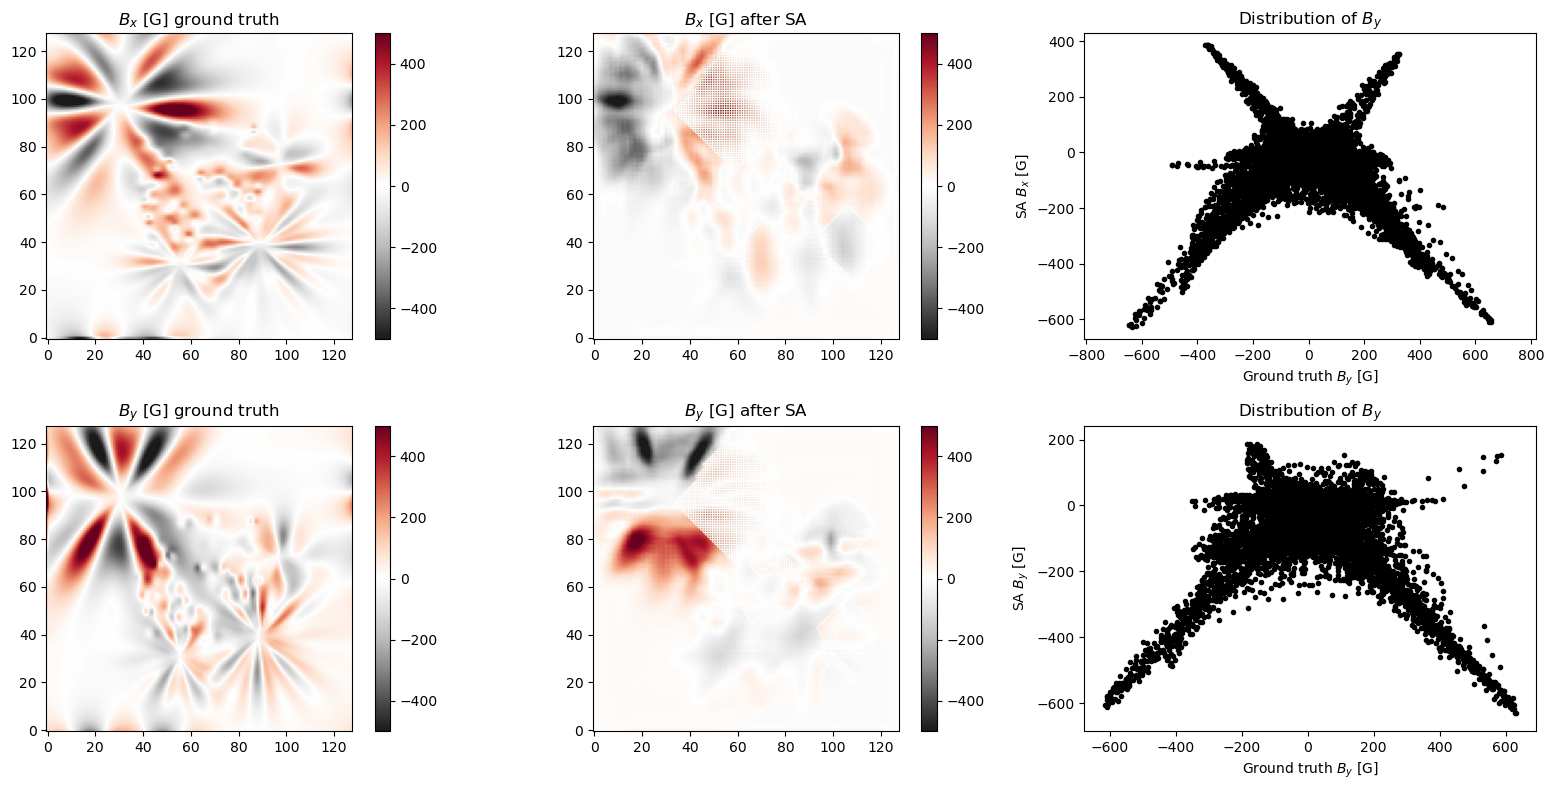

Bx correlation: 0.124, By correlation: 0.349


In [124]:
plt.figure(figsize=(16,8))
plt.subplot(231)
plt.imshow(Bx_flower, origin='lower', cmap='RdGy_r', vmin=-500, vmax=500)
plt.title('$B_x$ [G] ground truth')
plt.colorbar()
plt.subplot(232)
plt.imshow(Bx_dis, origin='lower', cmap='RdGy_r', vmin=-500, vmax=500)
plt.colorbar()
plt.title('$B_x$ [G] after SA')
plt.subplot(233)
plt.plot(Bx_flower.flatten(), Bx_pred.flatten(), 'k.')
plt.xlabel('Ground truth $B_y$ [G]')
plt.ylabel('SA $B_x$ [G]')
plt.axis('equal')
plt.title('Distribution of $B_y$')
plt.subplot(234)
plt.imshow(By_flower, origin='lower', cmap='RdGy_r', vmin=-500, vmax=500)
plt.colorbar()
plt.title('$B_y$ [G] ground truth')
plt.subplot(235)
plt.imshow(By_dis, origin='lower', cmap='RdGy_r', vmin=-500, vmax=500)
plt.colorbar()
plt.title('$B_y$ [G] after SA')
plt.subplot(236)
plt.plot(By_flower.flatten(), By_pred.flatten(), 'k.')
plt.xlabel('Ground truth $B_y$ [G]')
plt.ylabel('SA $B_y$ [G]')
plt.axis('equal')
plt.title('Distribution of $B_y$')
plt.tight_layout()
plt.show()

cc_Bx = np.corrcoef(Bx_dis.flatten(), Bx_flower.flatten())[0,1]
cc_By = np.corrcoef(By_dis.flatten(), By_flower.flatten())[0,1]

print(f"Bx correlation: {cc_Bx:.3f}, By correlation: {cc_By:.3f}")

We repeat whole procedure from before (with addition of azimuth).

In [125]:
Bx_pred = B_pred[0, 0, :, :].unsqueeze(0)  
By_pred = B_pred[0, 1, :, :].unsqueeze(0)  
Bz_pred = B_pred[0, 2, :, :].unsqueeze(0) 

I_obs_torch = stokes_torch[:, :, :, 0, :]  

V_synth = synthesize_stokes_V_wfa(Bz_pred, I_obs_torch, ll_tensor)
Q_synth, U_synth = synthesize_stokes_QU_wfa(Bx_pred, By_pred, I_obs_torch, ll_tensor, scale_factor=1e-8)

Bx_pred = Bx_pred[0].detach().cpu().numpy() 
By_pred = By_pred[0].detach().cpu().numpy()
Bz_pred = Bz_pred[0].detach().cpu().numpy()

V_pred = V_synth[0, :, :, :].detach().cpu().numpy()
Q_pred = Q_synth[0, :, :, :].detach().cpu().numpy()
U_pred = U_synth[0, :, :, :].detach().cpu().numpy()

V_obs = stokes_torch[0, :, :, 3, :].detach().cpu().numpy()
Q_obs = stokes_torch[0, :, :, 1, :].detach().cpu().numpy()
U_obs = stokes_torch[0, :, :, 2, :].detach().cpu().numpy()

print(f"\nGround truth Bx range: [{Bx_flower.min():.1f}, {Bx_flower.max():.1f}] G")
print(f"Ground truth By range: [{By_flower.min():.1f}, {By_flower.max():.1f}] G")
print(f"Ground truth Bz range: [{Bz_flower.min():.1f}, {Bz_flower.max():.1f}] G")

print(f"Final Bx range: [{Bx_pred.min():.1f}, {Bx_pred.max():.1f}] G")
print(f"Final By range: [{By_pred.min():.1f}, {By_pred.max():.1f}] G")
print(f"Final Bz range: [{Bz_pred.min():.1f}, {Bz_pred.max():.1f}] G")


Ground truth Bx range: [-645.3, 656.4] G
Ground truth By range: [-615.5, 630.2] G
Ground truth Bz range: [-2416.1, 2062.0] G
Final Bx range: [-632.1, 641.6] G
Final By range: [-584.7, 650.3] G
Final Bz range: [-1958.2, 1752.4] G


In [126]:
cc_Bx = np.corrcoef(Bx_flower.flatten(), Bx_pred.flatten())[0][1]
cc_By = np.corrcoef(By_flower.flatten(), By_pred.flatten())[0][1]
cc_Bz = np.corrcoef(Bz_flower.flatten(), Bz_pred.flatten())[0][1]
print(f"Bx correlation: {cc_Bx:.3f}, By correlation: {cc_By:.3f}, Bz correlation: {cc_Bz:.3f}")

cc_V = np.corrcoef(V_obs.flatten(), V_pred.flatten())[0][1]
cc_Q = np.corrcoef(Q_obs.flatten(), Q_pred.flatten())[0][1]
cc_U = np.corrcoef(U_obs.flatten(), U_pred.flatten())[0][1]
print(f"V correlation: {cc_V:.3f}, Q correlation: {cc_Q:.3f}, U correlation: {cc_U:.3f}")

Bt_pred = np.sqrt(Bx_pred**2 + By_pred**2)
Bt_true = np.sqrt(Bx_flower**2 + By_flower**2)

print(f"B transverse magnitude correlation: {np.corrcoef(Bt_pred.flat, Bt_true.flat)[0,1]:.3f}")

Bx correlation: -0.111, By correlation: -0.335, Bz correlation: 0.983
V correlation: 0.983, Q correlation: 0.886, U correlation: 0.878
B transverse magnitude correlation: 0.863


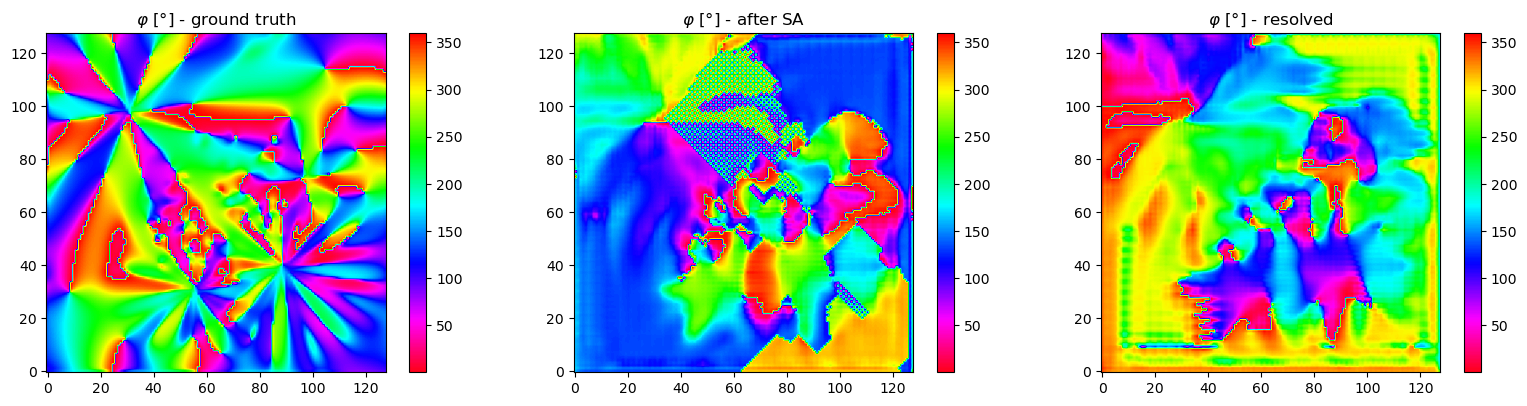

In [127]:
def azimuth(Bx, By):
    az = np.arctan2(By, Bx) * 180 / np.pi
    return az % 360

az_flower = azimuth(Bx_flower, By_flower)
az_dis = azimuth(Bx_dis, By_dis)
az_pred = azimuth(Bx_pred, By_pred)

plt.figure(figsize=(16,4))
plt.subplot(131)
plt.imshow(az_flower, origin='lower', cmap='hsv_r')
plt.title(r'$\varphi$ [°] - ground truth')
plt.colorbar()
plt.subplot(132)
plt.imshow(az_dis, origin='lower', cmap='hsv_r')
plt.colorbar()
plt.title(r'$\varphi$ [°] - after SA')
plt.subplot(133)
plt.imshow(az_pred, origin='lower', cmap='hsv_r')
plt.colorbar()
plt.title(r'$\varphi$ [°] - resolved')
plt.tight_layout()
plt.show()

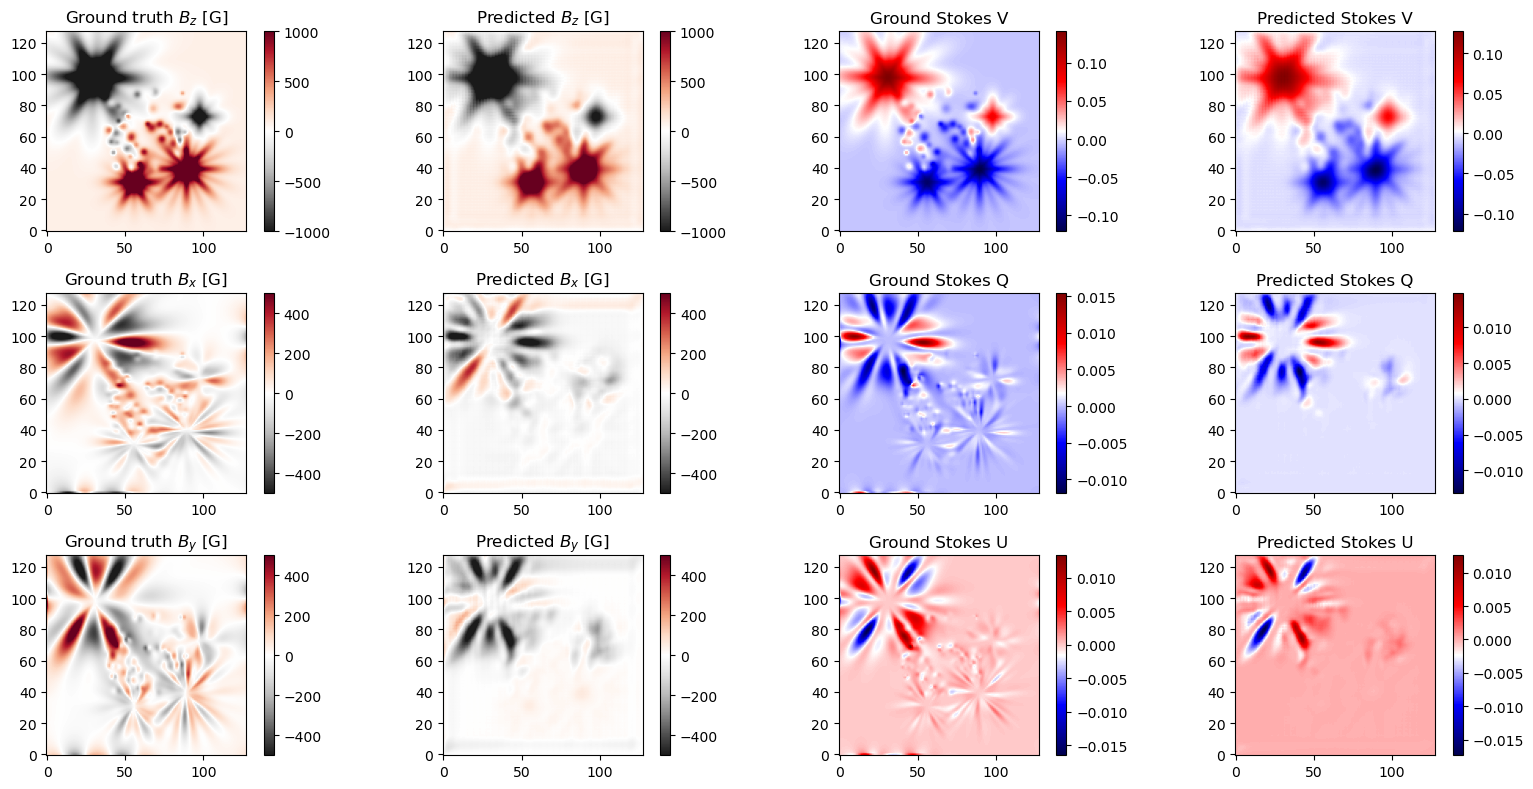

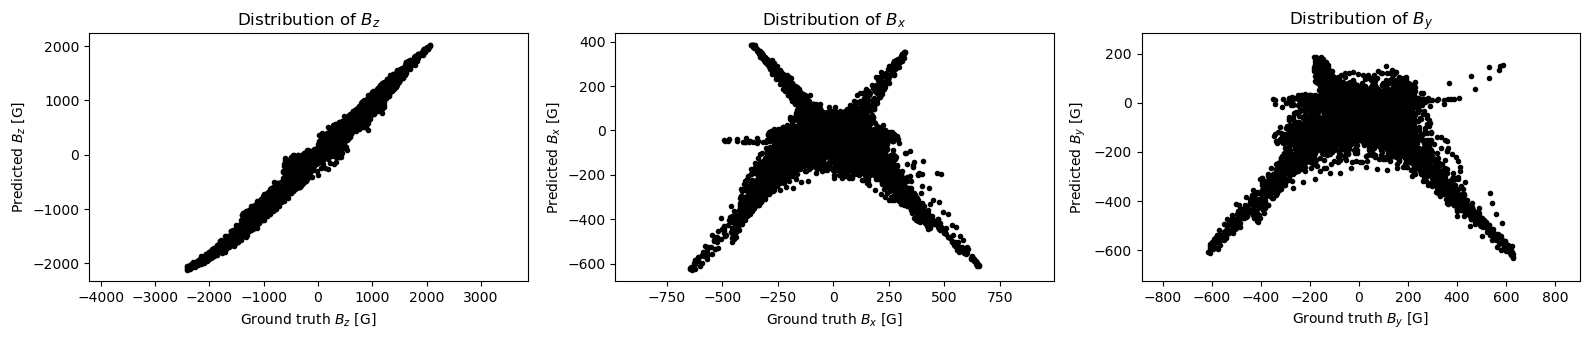

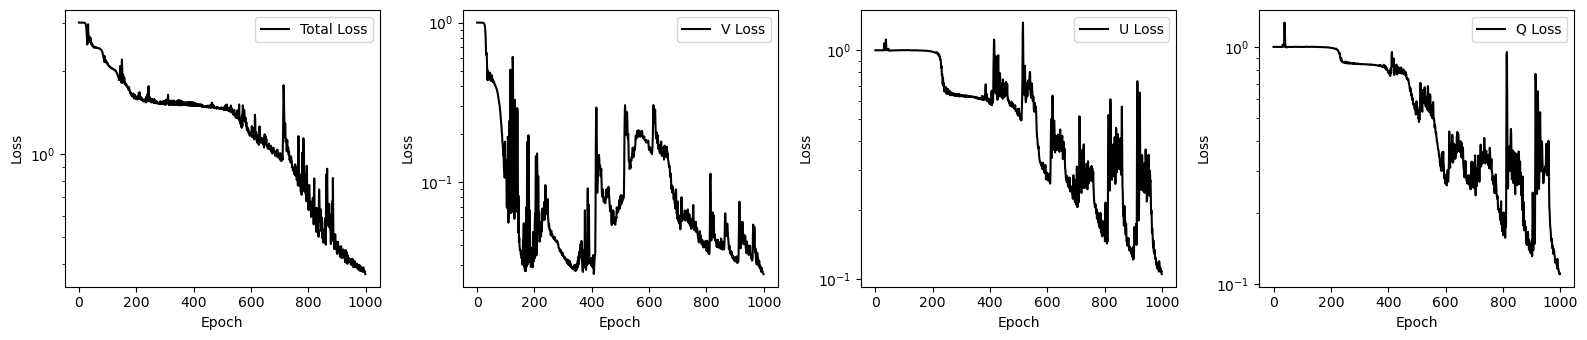

In [119]:
plt.figure(figsize=(16, 8))
plt.subplot(341)
plt.imshow(Bz_flower, origin='lower', cmap='RdGy_r', vmin=-1000, vmax=1000)
plt.colorbar()
plt.title(r'Ground truth $B_z$ [G]')
plt.subplot(342)
plt.imshow(Bz_pred, origin='lower', cmap='RdGy_r', vmin=-1000, vmax=1000)
plt.colorbar()
plt.title(r'Predicted $B_z$ [G]')
plt.subplot(343)
plt.imshow(V_obs[:,:,16], origin='lower', cmap='seismic')
plt.colorbar()
plt.title(r'Ground Stokes V')
plt.subplot(344)
plt.imshow(V_pred[:,:,16], origin='lower', cmap='seismic')
plt.colorbar()
plt.title(r'Predicted Stokes V')
plt.subplot(345)
plt.imshow(Bx_flower, origin='lower', cmap='RdGy_r', vmin=-500, vmax=500)
plt.colorbar()
plt.title(r'Ground truth $B_x$ [G]')
plt.subplot(346)
plt.imshow(Bx_pred, origin='lower', cmap='RdGy_r',vmin=-500, vmax=500)
plt.colorbar()
plt.title(r'Predicted $B_x$ [G]')
plt.subplot(347)
plt.imshow(Q_obs[:,:,16], origin='lower', cmap='seismic')
plt.colorbar()
plt.title(r'Ground Stokes Q')
plt.subplot(348)
plt.imshow(Q_pred[:,:,16], origin='lower', cmap='seismic')
plt.colorbar()
plt.title(r'Predicted Stokes Q')
plt.subplot(349)
plt.imshow(By_flower, origin='lower', cmap='RdGy_r', vmin=-500, vmax=500)
plt.colorbar()
plt.title(r'Ground truth $B_y$ [G]')
plt.subplot(3,4,10)
plt.imshow(By_pred, origin='lower', cmap='RdGy_r', vmin=-500, vmax=500)
plt.colorbar()
plt.title(r'Predicted $B_y$ [G]')
plt.subplot(3,4,11)
plt.imshow(U_obs[:,:,16], origin='lower', cmap='seismic')
plt.colorbar()
plt.title(r'Ground Stokes U')
plt.subplot(3,4,12)
plt.imshow(U_pred[:,:,16], origin='lower', cmap='seismic')
plt.colorbar()
plt.title(r'Predicted Stokes U')
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 3.5))
plt.subplot(131)
plt.plot(Bz_flower.flatten(), Bz_pred.flatten(), 'k.')
plt.title('Distribution of $B_z$')
plt.xlabel('Ground truth $B_z$ [G]')
plt.ylabel('Predicted $B_z$ [G]')
plt.axis('equal')
plt.subplot(132)
plt.plot(Bx_flower.flatten(), Bx_pred.flatten(), 'k.')
plt.title('Distribution of $B_x$')
plt.xlabel('Ground truth $B_x$ [G]')
plt.ylabel('Predicted $B_x$ [G]')
plt.axis('equal')
plt.subplot(133)
plt.plot(By_flower.flatten(), By_pred.flatten(), 'k.')
plt.xlabel('Ground truth $B_y$ [G]')
plt.ylabel('Predicted $B_y$ [G]')
plt.axis('equal')
plt.title('Distribution of $B_y$')
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,3.5))
plt.subplot(141)
plt.semilogy(loss_history, label='Total Loss', color='black')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(142)
plt.semilogy(loss_V_history, label='V Loss', color='black')
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.legend()
plt.subplot(143)
plt.semilogy(loss_U_history, label='U Loss', color='black')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(144)
plt.semilogy(loss_Q_history, label='Q Loss', color='black')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

We also take a look at energy functional *behaviour*.

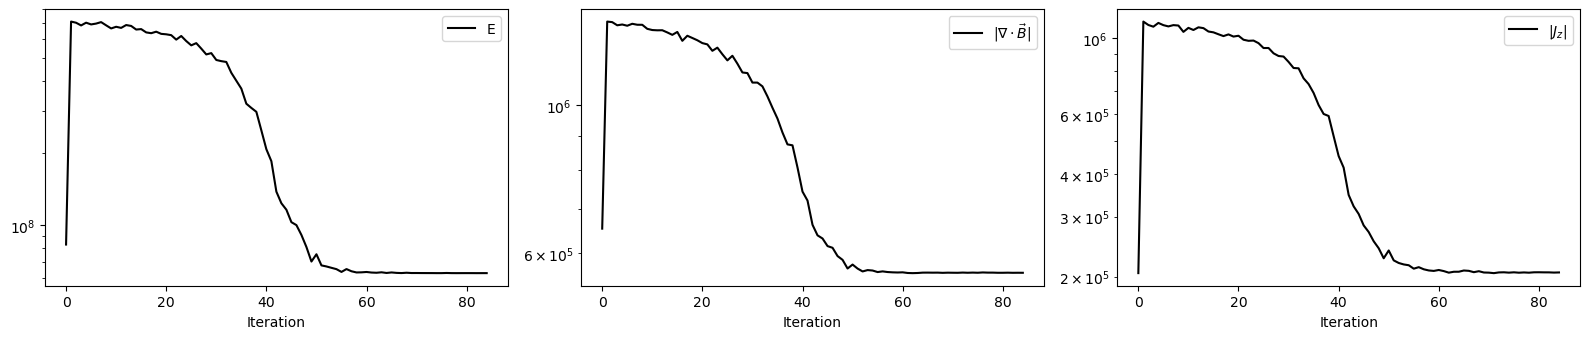

In [128]:
E, divB, jz = np.loadtxt('SA_behaviour.txt', unpack=True)
plt.figure(figsize=(16, 3.5))
plt.subplot(131)
plt.plot(E, label='E', color='black')
plt.yscale('log')
plt.xlabel('Iteration')
plt.legend()
plt.subplot(132)
plt.plot(divB, label=r'$|\nabla\cdot\vec{B}|$', color='black')
plt.yscale('log')
plt.xlabel('Iteration')
plt.legend()
plt.subplot(133)
plt.plot(jz, label=r'$|J_z|$', color='black')
plt.yscale('log')
plt.xlabel('Iteration')
plt.legend()
plt.tight_layout()
plt.show()